**This notebook applies our models to test input to predict objects' heights and class seperately, finally combine them.**

In [1]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

import time
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

Lyft SDK requires creating a link to input folders

In [2]:
!rm ./images
!rm ./maps
!rm ./lidar
!ln -s /home/jupyter/project/data/test_images images
!ln -s /home/jupyter/project/data/test_maps maps
!ln -s /home/jupyter/project/data/test_lidar lidar

### A. Creating a new test data class

In [3]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

In [4]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

level5data = LyftTestDataset(data_path='.', json_path='./data/test_data', verbose=True)

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 3.3 seconds.
Reverse indexing ...
Done reverse indexing in 1.5 seconds.


In [5]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)
        
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)        

In [6]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

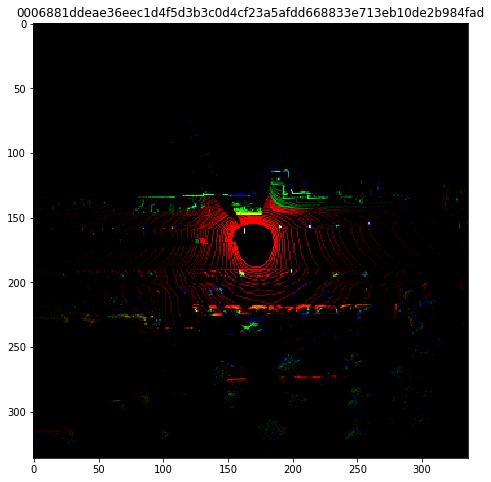

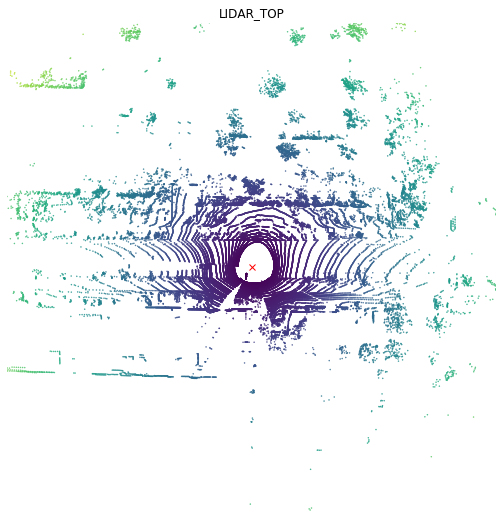

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)        
        im = im.astype(np.float32)/255
        im = torch.from_numpy(im.transpose(2,0,1))
        return im, sample_token

    
test_data_folder = './artifacts/bev_test_data'
input_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_input.png")))

test_dataset = BEVImageDataset(input_filepaths)
    
im, sample_token = test_dataset[1]
im = im.numpy()

plt.figure(figsize=(16,8))

# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
# plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.imshow(im.transpose(1,2,0)[...,:3])
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

### B. Define classification & height model structure

In [9]:
import torchvision

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnetEncoderClf(nn.Module):
    DEPTH = 5

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet34(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(256, 256)
        up_blocks.append(UpBlockForUNetWithResNet(256, 128))
        up_blocks.append(UpBlockForUNetWithResNet(128, 64))
        up_blocks.append(UpBlockForUNetWithResNet(in_channels=64+64, out_channels=64, up_conv_in_channels=64, up_conv_out_channels=64))
        up_blocks.append(UpBlockForUNetWithResNet(in_channels=32+3, out_channels=32, up_conv_in_channels=64, up_conv_out_channels=32))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(32, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)
        
        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnetEncoderClf.DEPTH - 1):
                break
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnetEncoderClf.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

class UNetWithResnetEncoderReg(nn.Module):
    DEPTH = 5

    def __init__(self): # remove n_classes
        super().__init__()
        resnet = torchvision.models.resnet.resnet34(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(256, 256)
        up_blocks.append(UpBlockForUNetWithResNet(256, 128))
        up_blocks.append(UpBlockForUNetWithResNet(128, 64))
        up_blocks.append(UpBlockForUNetWithResNet(in_channels=64+64, out_channels=64, up_conv_in_channels=64, up_conv_out_channels=64))
        up_blocks.append(UpBlockForUNetWithResNet(in_channels=32+3, out_channels=32, up_conv_in_channels=64, up_conv_out_channels=32))

        self.up_blocks = nn.ModuleList(up_blocks)
        #print(len(up_blocks))

        self.out = nn.Conv2d(32, 1, kernel_size=1, stride=1) # output channel is only 1, which is the predicted height

    def forward(self, x, with_output_feature_map=False):
        
        batch, channel, h, w = x.shape
        
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)
        
        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            #print(f'iter {i}', x.shape)
            if i == (UNetWithResnetEncoderReg.DEPTH - 1):
                break
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnetEncoderReg.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        x = x.view(batch, h, w)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### C. Loading trained model

In [12]:
ARTIFACTS_FOLDER = './artifacts'
class_model = UNetWithResnetEncoderClf(1 + len(classes))
height_model = UNetWithResnetEncoderReg()

epoch_to_load=5
checkpoint_filename = "resnet2_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, 'checkpoints', checkpoint_filename)
class_model.load_state_dict(torch.load(checkpoint_filepath))
class_model = class_model.to(device)
class_model.eval();

epoch_to_load=10
checkpoint_filename = "resnet34_height_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, 'checkpoints', checkpoint_filename)
height_model.load_state_dict(torch.load(checkpoint_filepath))
height_model = height_model.to(device)
height_model.eval();

In [14]:
def calc_detection_box(prediction_opened,class_probability,height):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    sample_detection_heights = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            box_height = height[box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]
            
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_center_value)
            sample_detection_heights.append(box_height)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes,sample_detection_heights

### D. Test Set Predictions

In [15]:
import gc
gc.collect()

batch_size = 16
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*4)
progress_bar = tqdm_notebook(test_loader)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []
detection_heights = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 200

with torch.no_grad():
    class_model.eval()
    height_model.eval()
    for ii, (X, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = class_model(X)  # [N, 10, H, W]
        prediction = F.softmax(prediction, dim=1)
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        # Get height estimation
        heights = height_model(X).cpu().numpy() # [N, H, W]
        heights = np.clip(heights, 0, 100)
        
        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes, sample_detection_heights = calc_detection_box(predictions_opened[i],
                                                                                                                         predictions[i],
                                                                                                                         heights[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)
            detection_heights.append(sample_detection_heights)

Total amount of boxes: 776104


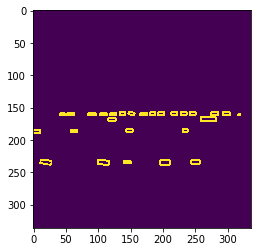

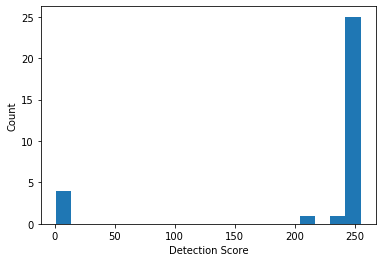

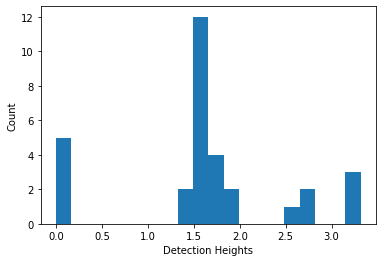

In [16]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    
# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

# Visualize their heights
plt.hist(detection_heights[0], bins=20)
plt.xlabel("Detection Heights")
plt.ylabel("Count")
plt.show()

### E. Transform predicted boxes back into world space

In [17]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [18]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
pred_box3ds = []

for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class, sample_detection_height) \
        in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes, detection_heights), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)
    
    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]

    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_height = np.array(sample_detection_height)
    sample_boxes_centers[:,2] += sample_height/2

    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = sample_detection_height # box_heights

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))

        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])
        size[2] = max(0.01, size[2])
        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


In [19]:
pred_box3ds[0]

{'sample_token': 'd21ead69515ccf948160adba0f39c7e2c9daeffa52e77b15b9b572ace5866852', 'translation': [2411.897887127558, 878.1354489833503, -18.806978789552772], 'size': [5.499999658670934, 1.9994283475941403, 1.6764355897903442], 'rotation': [0.8710393120464379, 0.0, 0.0, 0.4912133109654789], 'name': 'car', 'volume': 18.435519482178556, 'score': 254.0}

### F. Creating Submission File

In [20]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('./data/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

In [21]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

,Id,PredictionString
0,d21ead69515ccf948160adba0f39c7e2c9daeffa52e77b...,0.996078431372549 2411.897887127558 878.135448...
1,179050aaccacbaef7aca62ee3ef951858186c2f3a170d9...,1.0 2056.029651579025 1097.9968263277508 -18.3...
2,3d8ec1354f84e39b934043c587ffdf418712edda27a231...,1.0 2090.709477274815 1040.843967399528 -18.54...
3,ea570fbf65888f2969012914e8fed092977ccb3301488a...,0.00392156862745098 2479.0677784369122 837.451...
4,097c87462c72b3f47094e1b4f46676d9e16b1593c1ce38...,1.0 1965.133291199571 1087.9262251036519 -18.3...


In [22]:
sub.to_csv('lyft3d_pred_combined.csv',index=False)

In [23]:
sub.shape

(27468, 2)